# Spark Data Pipeline and Dashboards


This workspace gives a rudimentary view of how ETL pipeline gets build, transform and loaded in Spark Dataframes (temporary view) which acts as table/dataset and those dataset are used for further Analytics and Reporting. There are multiple approaches to build a pipeline and make the data ready for analysis. While making a decision I took all factors are taken into consideration to mention a few. data integrations, scalability, cost-efficiency, batch or stream processing, usabability. 

### Summary:
    1. Introduction
     - Spark Understanding 
     - ETL Architecture
     - Schema for Dataset
    
    2. Data Extraction 
     - Spark Partition
    
    3. Data Transformation
     - Spark API's
    
    4. Data Loading 
     - Star Schema 
    
    5. Analytics and Dashboards
     - User Behavior Analytics
     - Campaign Analytics
     - Product Analytics

### 1. Introduction 
        
Spark popularity has grown in recent years reason being the in memory computation provided by RDD Data Model (Resilent Distributed Dataset) which eliminates the intermediate disk read/write task results in faster execution. Moreover, Spark uses (DAG) directed acyclic graph execution engine that optimizes iterative, iteractive, and on-demand computations which Hadoop's MapReduce system lacks on single dataset. Hadoop is more cost effective while it comes to handling massive dataset but the real time data processing capability gives Spark an upper hand as choice for Big data Analytics. 
    
I preferred Spark framework to implement data pipeline as our dataset isn't big enough, additionally getting the benefit of Spark having atleast 100 times faster than Hadoop MapR. In below project workspace, I will be creating a schema according to dataset column data types, this defines the structure for Dataframe (df_master) which is storing the data in tabular format in Spark dataframe and make data ready for transformation. Further making a use of temporary view to create tables, it does not persist the memory until we cache the dataset.Additionally, we can also saveAsTable and write the data into external data source.Thus, both ways dataframe and external data can be used for analysis purpose. 
    
With this project, I wanted to try a new approach which will be more efficient than what I implemented in my all previous approaches (Link references available at end of notebook), But the above approach really convinced me to go with Spark, Jupyter notebook, Plotly, matplotlib. For the Databricks community edition dataset upload size wasn't allowed beyond 2GB, So I stick to the plan and proceed with Spark framework.
    
Following architecture shows the implemented Data Pipeline flow: 
        
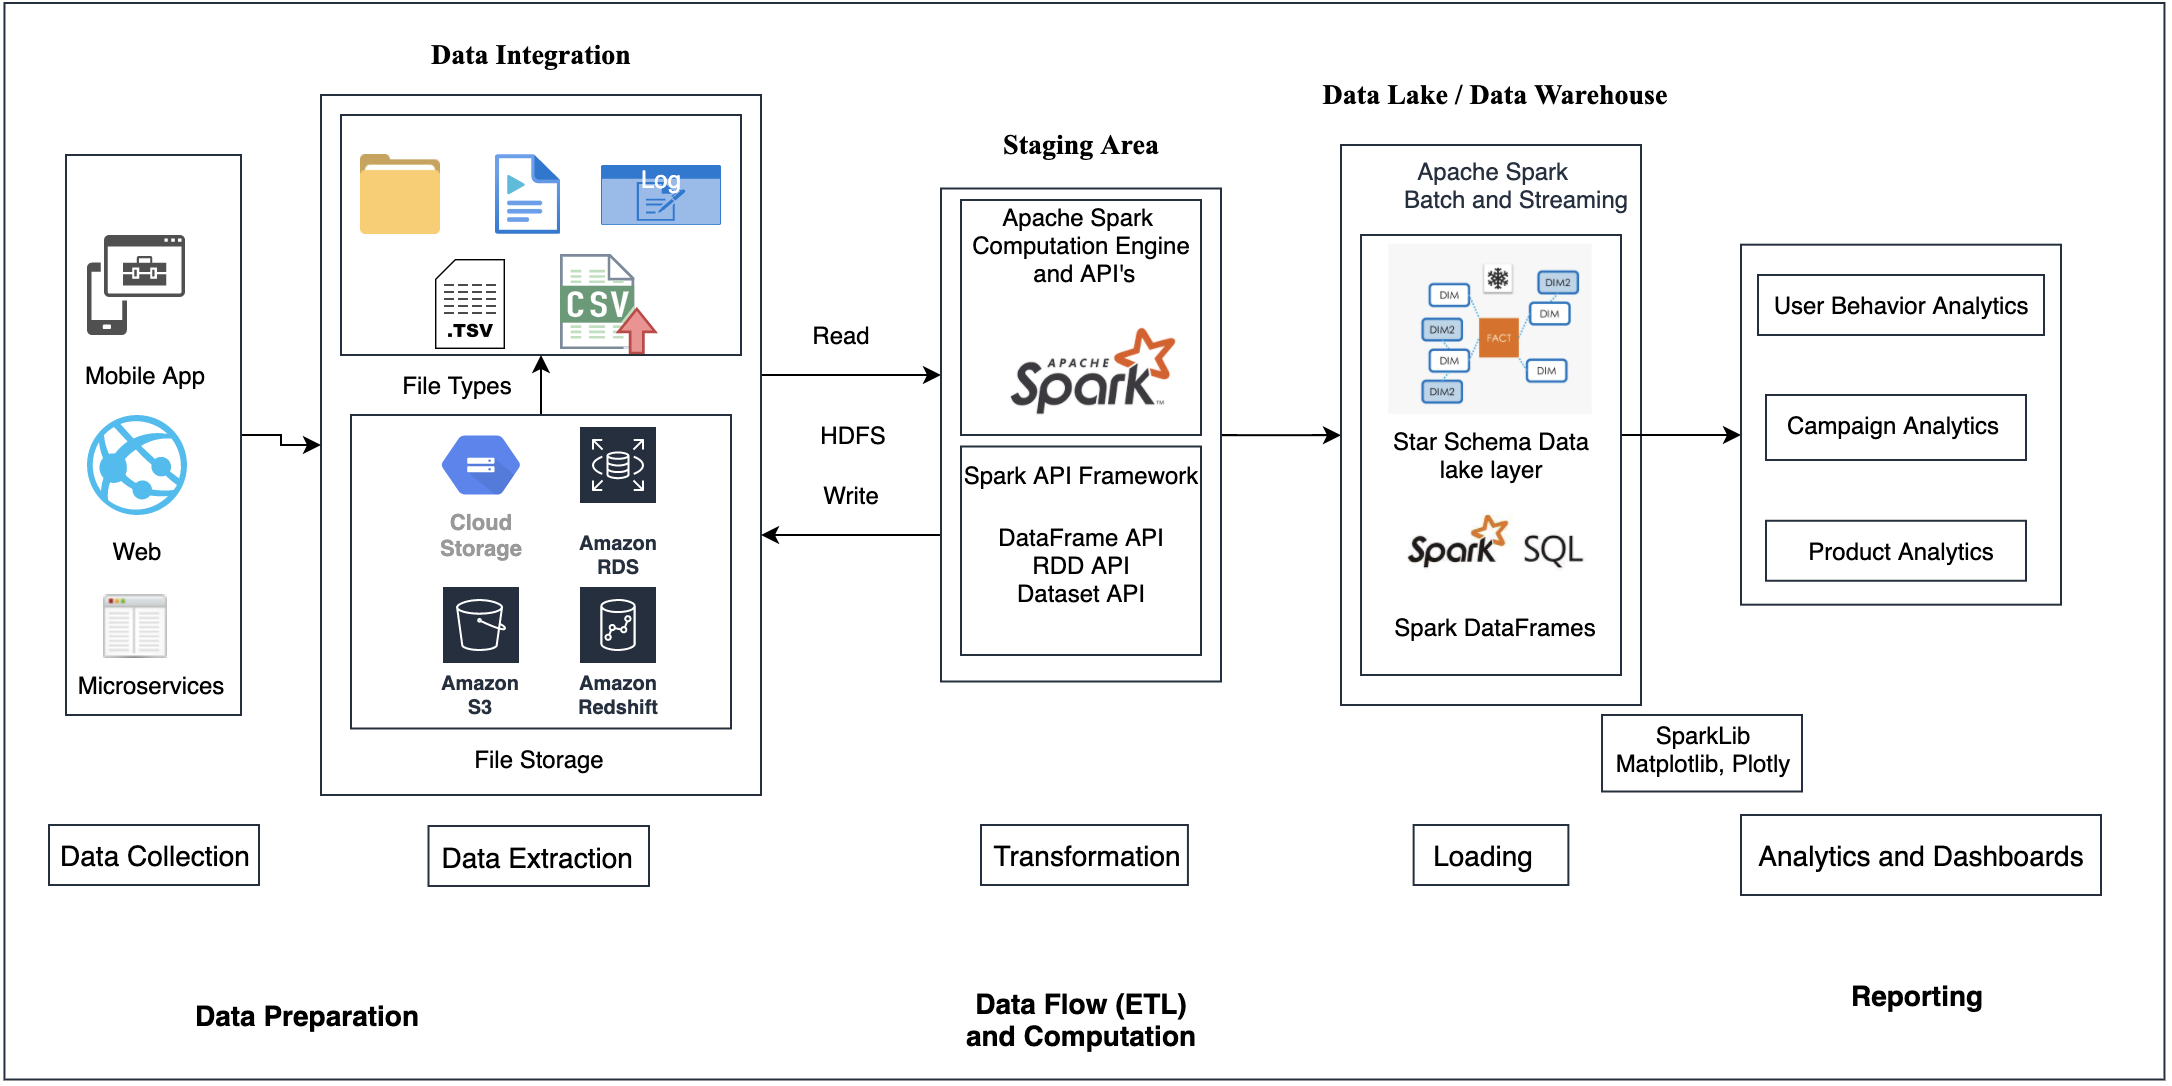

#### <center>Fig.1. ETL Pipeline Architecture <center>

In [1]:
#To use the RDD and creating clusters 
from pyspark import SparkContext  

#To use the Spark API's(Dataframe, Dataset, RDD)
from pyspark.sql import SparkSession 

#To use the SQL function and queries
from pyspark.sql import SQLContext 
from pyspark.sql.functions import *
from pyspark.sql.types import*
from pyspark.sql import functions as F

In [2]:
# For visualization using plotly( Name converted to chart studio recently)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import chart_studio.plotly as py
import chart_studio
chart_studio.tools.set_credentials_file(username='mohitcpatil', api_key='M9kECA2ayXcvxG3Xdqvw')

# For plotting interactive charts 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

# To interact with file and operating system  
import os

#To use pandas dataframe and set the column and row limits for display windows 
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Visualization 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%autosave

UsageError: %autosave requires an integer, got ''


In [ ]:
# For visuals to embed inside the notebook
init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
# To filter and disable the warnings from modules
warnings.filterwarnings("ignore")

#### Spark Session

In [6]:
# Creating the Spark session  which encapsulates all the API's (Dataframe, Dataset, RDD, SQL)
if __name__ == '__main__':
    scSpark = SparkSession.builder.appName("thredUP Assessment").getOrCreate()         

In [7]:
#Apache Spark version
scSpark

### User defined schema 

Our dataset does not contain header column row. Thus, we are going to create a user defined schema which provides the structure of the Dataframe. Other way can be inferring the schema from the input file and the one we are implementing is providing the Schema while reading the file. It's having added benefit making faster execution by placing the correct columns types in the dataframe.As in oppose Inferschema makes an extra pass over the file to infer the column types. 

StructType data type has collection of StructField as created in Master_Schema in below cell

In [8]:
Master_schema = StructType([StructField("user_id",IntegerType(),True),StructField("device_id",StringType(),True),
                     StructField("event_type",StringType(),True),StructField("insert_id",StringType(),True),
                     StructField("event_time",TimestampType(),True),StructField("session_id",StringType(),True),
                     StructField("session_start",TimestampType(),True),StructField("session_end",TimestampType(),True),
                     StructField("platform",StringType(),True),StructField("uprop_app_download_ts",FloatType(),True),
                     StructField("revenue",FloatType(),True),StructField("location_lat",FloatType(),True),
                     StructField("location_lng",FloatType(),True),StructField("app_version",StringType(),True),
                     StructField("carrier",StringType(),True),StructField("os_version",StringType(),True),
                     StructField("uprop_item_order_count",IntegerType(),True),StructField("uprop_bag_req_count",IntegerType(),True),
                     StructField("uprop_last_purchase_ts",TimestampType(),True),StructField("uprop_first_purchase_ts",TimestampType(),True),
                     StructField("uprop_total_revenue",FloatType(),True),StructField("uprop_zip5",IntegerType(),True),
                     StructField("uprop_state",StringType(),True),StructField("uprop_msa_group_name",StringType(),True),
                     StructField("uprop_median_income",IntegerType(),True),StructField("uprop_hamlet_score",IntegerType(),True),
                     StructField("uprop_user_treatments",IntegerType(),True),StructField("uprop_orders_completed_lifetime",FloatType(),True),
                     StructField("uprop_user_credit_balance",IntegerType(),True),
                     StructField("uprop_user_promotion_code",IntegerType(),True),StructField("uprop_total_session_count",IntegerType(),True),
                     StructField("uprop_total_favorites",IntegerType(),True),StructField("uprop_dom_referrer",StringType(),True),
                     StructField("uprop_utm_term",StringType(),True),StructField("uprop_utm_source",StringType(),True),
                     StructField("uprop_utm_medium",StringType(),True),StructField("uprop_utm_content",StringType(),True),
                     StructField("uprop_utm_email",StringType(),True),StructField("uprop_utm_campaign",StringType(),True),
                     StructField("uprop_referral_code",IntegerType(),True),StructField("uprop_acq_signup_platform",StringType(),True),
                     StructField("uprop_acq_signup_channel",StringType(),True),StructField("uprop_acq_signup_sub_channel",StringType(),True),
                     StructField("uprop_acq_invitation_code",StringType(),True),StructField("uprop_acq_external_referrer",StringType(),True),
                     StructField("uprop_acq_signup_method_agg",StringType(),True),StructField("uprop_acq_signup_method",StringType(),True),
                     StructField("uprop_paid_acq_bucket",StringType(),True),
                     StructField("eprop_order_id",IntegerType(),True),StructField("eprop_order_type",StringType(),True),
                     StructField("eprop_pay_with",StringType(),True),StructField("eprop_order_contains_bag",FloatType(),True),
                     StructField("eprop_total_shipping_fees",IntegerType(),True),StructField("eprop_total_tax",IntegerType(),True),
                     StructField("eprop_total_discount",IntegerType(),True),StructField("eprop_item_qty",FloatType(),True),
                     StructField("eprop_order_asp",IntegerType(),True),StructField("eprop_total_cash_credits_used",FloatType(),True),
                     StructField("eprop_item_order_seq",IntegerType(),True),StructField("eprop_cart_id",IntegerType(),True),
                     StructField("eprop_app_id",StringType(),True),StructField("eprop_device_model",StringType(),True),
                     StructField("eprop_device_resolution",IntegerType(),True),StructField("eprop_link_name",StringType(),True),
                     StructField("eprop_event_mythredup_sections",StringType(),True),StructField("eprop_cleanout_section",StringType(),True),
                     StructField("eprop_prod_dept",StringType(),True),
                     StructField("eprop_pagination_no",IntegerType(),True),StructField("eprop_prod_merch_dept",StringType(),True),
                     StructField("eprop_prod_state",StringType(),True),StructField("eprop_prod_list_price",FloatType(),True),
                     StructField("eprop_prod_name",StringType(),True),StructField("eprop_prod_id",IntegerType(),True),
                     StructField("eprop_dept_tags",IntegerType(),True), 
                     StructField("eprop_sort_by",StringType(),True),StructField("eprop_prod_color",StringType(),True),
                     StructField("eprop_prod_condition",StringType(),True),StructField("eprop_prod_discount",StringType(),True),
                     StructField("eprop_prod_sizing_id",FloatType(),True),StructField("eprop_prod_category",IntegerType(),True),
                     StructField("eprop_search_keywords",StringType(),True),StructField("eprop_search_result_count",IntegerType(),True),
                     StructField("eprop_filter_type",StringType(),True),StructField("eprop_promo_code",StringType(),True),
                     StructField("eprop_promo_code_error",StringType(),True),StructField("eprop_atc_from",StringType(),True),
                     StructField("eprop_customer_status",StringType(),True),StructField("eprop_plp_url",StringType(),True)])    



------

### 2. Data Extraction

In [9]:
#Read the file and infer the above created schema
#Here, we are working with tab separated value file. There are few other file formats more popular are JSON, parquet, and CSV.

df_master = scSpark.read.options(header='False', delimiter="\t")\
                        .schema(Master_schema)\
                        .csv("/Users/mohitpatil/Downloads/Chrome/thredUP/events.tsv")

-----

In [10]:
#Converting DataFrame to Pandas

df_master.limit(10).toPandas() 

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3.0,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,2017-12-01 07:21:13,2017-12-01 08:13:54,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4.0,0.0,NaN,54,NaN,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,women,None,11.0,None,None,NaN,None,NaN,NaN,Price Low to High,None,None,None,NaN,NaN,None,NaN,Sizes,None,None,None,logged_in,/products/women
2,14204551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,2017-12-01 07:34:22,2017-12-01 08:01:07,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3.0,NaN,NaN,67,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thredUP 7.7.1,iPhone,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,2017-12-01 06:16:29,2017-12-01 08:07:10,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5.0,0.0,NaN,15,NaN,www.google.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None,NaN,women,listed,70.989998,Banana Republic Wool Coat,27374860.0,NaN,None,Gray,Q1_only,0.76,795.0,813.0,No

#### A user defined schema for master dataframe

In [11]:
df_master.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- device_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- insert_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- session_id: string (nullable = true)
 |-- session_start: timestamp (nullable = true)
 |-- session_end: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- uprop_app_download_ts: float (nullable = true)
 |-- revenue: float (nullable = true)
 |-- location_lat: float (nullable = true)
 |-- location_lng: float (nullable = true)
 |-- app_version: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- os_version: string (nullable = true)
 |-- uprop_item_order_count: integer (nullable = true)
 |-- uprop_bag_req_count: integer (nullable = true)
 |-- uprop_last_purchase_ts: timestamp (nullable = true)
 |-- uprop_first_purchase_ts: timestamp (nullable = true)
 |-- uprop_total_revenue: float (nullable = true)
 |-- uprop_zip5: integer (nullable = t

### Spark Partitions

A spark job should be well distributed across the cluster and it depends on number of partition available for the dataframe. below we have master dataframe distributed across 25 partitions.In order to increase the partitions we can use repartition() method to redistribute the data across multiple partitions. 

#### Master dataframe current partitions

In [12]:
print("Partitions present {0}".format(df_master.rdd.getNumPartitions()))

Partitions present 25


#### Repartition the master dataframe with 50 partition

In [13]:
#df_master = df_master.repartition(50).cache()


In [14]:
#print("Partitions present {0}".format(df_master.rdd.getNumPartitions()))

-----

## 3. Data Transfomation

Before going ahead I need to decide on which Spark API framework will be utilizing among available (RDD, Dataset, Dataframe). RDD API is the one available right from start of Spark invention, It is most useful when it comes to unstructured data format (Media, row data). As our dataset is in tablular format we will be using Dataframe API. 

Spark framework API's such as spark dataset and dataframes are utilizing the SparkSession. whereas SparkContext is used specifically when working with RDD and creating a spark clusters.
With the recent update on Apache Spark 2.2.0 everything has been encapsulated with SparkSession, so we don't need to use sepecially Hive Context, Spark Conetxt, and SQL Context.

For the whole course of transformation we will use df_master and df_master_transform dataframe for transformations. Then, df_master dataframe is used for loading into fact and dimension tables in Star Schema format. 

Transformation usually have two steps:

   - Transformation : It performs the certain transformations on given RDD, Dataframe, Dataset such as filter(), withColumn(), groupby() just like we did below. This process generally does not change the data and creates a new RDD 
   - Actions : Few of the transformations we used below to mention by taking action such as counting the values and taking first 5 rows. Action creates the smaller dataset such as count(), aggragate(), distinct() etc. are few examples of them. 
   
Transformations performed as per the requirement and need of data, In our dataset values in few of the columns are null and missing, otherwise most of the present data is clean.


### Remove the decimal point 0 from customer orders lifetime and user_id column 

In [15]:
# Using the withColumn function to manipulate the column values 

df_master = df_master\
                     .withColumn('uprop_orders_completed_lifetime', translate('uprop_orders_completed_lifetime', '.0', ''))

df_master = df_master\
                     .withColumn('user_id', translate('user_id', '.0', ''))

df_master.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,2017-12-01 07:21:13,2017-12-01 08:13:54,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4,0.0,NaN,54,NaN,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,women,None,11.0,None,None,NaN,None,NaN,NaN,Price Low to High,None,None,None,NaN,NaN,None,NaN,Sizes,None,None,None,logged_in,/products/women
2,1424551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,2017-12-01 07:34:22,2017-12-01 08:01:07,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,67,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thredUP 7.7.1,iPhone,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,2017-12-01 06:16:29,2017-12-01 08:07:10,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5,0.0,NaN,15,NaN,www.google.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None,NaN,women,listed,70.989998,Banana Republic Wool Coat,27374860.0,NaN,None,Gray,Q1_only,0.76,795.0,813.0,None,NaN,No

--------

### Fill column eprop_prod_merch_dept with appropriate value 

- There are some irrelevant values present in the merchadise department column which we are going to replace with meaningful value.

In [16]:
df_master = df_master\
                    .withColumn('eprop_prod_merch_dept', translate('eprop_prod_merch_dept', 'X', 'Others'))

df_master.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,2017-12-01 07:21:13,2017-12-01 08:13:54,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4,0.0,NaN,54,NaN,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,women,None,11.0,None,None,NaN,None,NaN,NaN,Price Low to High,None,None,None,NaN,NaN,None,NaN,Sizes,None,None,None,logged_in,/products/women
2,1424551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,2017-12-01 07:34:22,2017-12-01 08:01:07,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,67,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thredUP 7.7.1,iPhone,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,2017-12-01 06:16:29,2017-12-01 08:07:10,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5,0.0,NaN,15,NaN,www.google.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None,NaN,women,listed,70.989998,Banana Republic Wool Coat,27374860.0,NaN,None,Gray,Q1_only,0.76,795.0,813.0,None,NaN,No

### Filter the column with specified value

- Filter transformation are used same as where clause in SQL to return the rows matched with condition.  

In [17]:
#filter the dataframe for user having device model LG

df_master_transform = df_master.where((col("eprop_device_model") == "HTCONE" ))

df_master_transform.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,94024fda-dd32-4d83-9046-b0954f15fede,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
2,16878712,89ae640fa58e4f26897354a8d880df42,View Product listing Page (PLP),656a64b9-06d9-43a9-adf0-1e6ed9c39a46,2017-12-01 08:00:08,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,16878712,89ae640fa58e4f26897354a8d880df42,View Product listing Page (PLP),3ff70ff3-61e3-49e9-99dd-3f8afe2e9aa2,2017-12-01 08:00:08,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
4,16878712,89ae640fa58e4f26897354a8d880df42,View Product listing Page (PLP),7609d4ab-fd90-489c-88c5-ec55

### Change data types of the column
- WithColumn function provides usage on dataframe such as adding the column, altering the values, deriving new columns from existing and in below case we are converting the datatype of column with cast function 

In [18]:
df_master_transform = df_master\
                            .withColumn("eprop_total_tax", df_master["eprop_total_tax"].cast(FloatType()))

df_master_transform.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,2017-12-01 07:21:13,2017-12-01 08:13:54,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4,0.0,NaN,54,NaN,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,women,None,11.0,None,None,NaN,None,NaN,NaN,Price Low to High,None,None,None,NaN,NaN,None,NaN,Sizes,None,None,None,logged_in,/products/women
2,1424551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,2017-12-01 07:34:22,2017-12-01 08:01:07,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,67,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thredUP 7.7.1,iPhone,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,2017-12-01 06:16:29,2017-12-01 08:07:10,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5,0.0,NaN,15,NaN,www.google.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None,NaN,women,listed,70.989998,Banana Republic Wool Coat,27374860.0,NaN,None,Gray,Q1_only,0.76,795.0,813.0,None,NaN,No

### Drop duplicates from column

In [19]:
df_master_transform.select("event_type").dropDuplicates().sort("event_type").limit(10).toPandas()

,event_type
0,-
1,Add to cart
2,Address update failed
3,Address update successfull
4,App Download
5,Click from email to reset password
6,Clicks on Place order button
7,Credit card info validation failed
8,Favorited
9,Login Failure


### Count Null Values

In [20]:
#df_master_transform.select([count(when(col(c).isNull(), c)).alias(c) for c in df_master_transform.columns]).show(vertical=True)

In [21]:
#df_master_transform.limit(10).toPandas()

In [22]:
# Drop the column or row if any NA values found

#df_master_transform = df_master.dropna(how='any')

### Describe column Product list price

To get the statistical data such as mean, max, standard daviation for mixed data types. 

In [23]:
%%time
df_master_transform.describe(['eprop_prod_list_price']).show()

+-------+---------------------+
|summary|eprop_prod_list_price|
+-------+---------------------+
|  count|              2331425|
|   mean|   31.376294601424313|
| stddev|    74.25558852877613|
|    min|                  0.0|
|    max|              3599.99|
+-------+---------------------+

CPU times: user 2.63 ms, sys: 2.19 ms, total: 4.82 ms
Wall time: 13.6 s


### Query with Keyword ,contains and multiple conditions

In [24]:
# Startswith function search the specified keyword to match

df_master_transform.filter(df_master["app_version"].startswith("4")).limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,94024fda-dd32-4d83-9046-b0954f15fede,2017-12-01 08:00:03,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
2,16878712,89ae640fa58e4f26897354a8d880df42,View Product listing Page (PLP),656a64b9-06d9-43a9-adf0-1e6ed9c39a46,2017-12-01 08:00:08,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
3,16878712,89ae640fa58e4f26897354a8d880df42,View Product listing Page (PLP),3ff70ff3-61e3-49e9-99dd-3f8afe2e9aa2,2017-12-01 08:00:08,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,HTCONE,NaN,None,None,women,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,No Filters,None,None,None,logged_in,None
4,795761,1f6f3d51c973458a8a9e873734eaf9a6,View Product details page (PDP),ad2a2c14-e8e3-420a-bf2e-98d7a8

### Search with values contains (Product name with jeans)

In [25]:
df_master_transform.filter(df_master["carrier"].contains("Sprint")).limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,session_start,session_end,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,eprop_cart_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,eprop_prod_dept,eprop_pagination_no,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_prod_id,eprop_dept_tags,eprop_sort_by,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,eprop_promo_code,eprop_promo_code_error,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,9498665,01543fccd0bb00038bff6dbfeb870006e008906600432,View Product details page (PDP),28866d25-1bcf-4612-920a-9f120c028c3a,2017-12-01 08:01:37,1512115242000,2017-12-01 08:00:42,2017-12-01 08:14:12,ios,NaN,NaN,NaN,NaN,7.7.4,Sprint,10.3.3,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,4,NaN,NaN,75,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thredUP 7.7.4,iPhone,NaN,None,None,None,None,NaN,O,None,70.989998,None,28302351.0,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
1,9619492,AE7049EF09814F9C8821F47BAD6B8DBA,Add to cart,19dffc30-7cd3-44aa-a59b-410adf796b92,2017-12-01 08:03:53,1512115353000,2017-12-01 08:02:33,2017-12-01 08:04:29,ios,NaN,NaN,NaN,NaN,7.7.8,Sprint,11.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,4,NaN,NaN,299,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"iPhone9,1",NaN,None,None,None,None,NaN,None,None,NaN,None,28242664.0,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,shop-details,logged_in,None
2,38457851,A87F73C5AE2B4D9D9F056E397CE2B4E4,Clicks on Place order button,24eca07f-961c-49a6-958b-a92880d7b532,2017-12-01 08:04:11,1512115312000,2017-12-01 08:01:52,2017-12-01 08:04:11,ios,NaN,NaN,NaN,NaN,7.7.8,Sprint,11.1.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,1,NaN,NaN,7,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"iPhone9,2",NaN,None,None,None,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
3,13787541,67E6983906874632943D833DF691A22D,View Product details page (PDP),27e5a877-c9ff-4820-b594-47d64ca0ab78,2017-12-01 08:06:19,1512115498000,2017-12-01 08:04:58,2017-12-01 08:17:12,ios,NaN,NaN,NaN,NaN,7.7.8,Sprint,11.1.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,4,NaN,NaN,217,NaN,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,iPhone 6s,NaN,None,None,None,None,NaN,women,None,14.990000,None,28529553.0,NaN,None,None,None,None,NaN,NaN,None,NaN,None,None,None,None,logged_in,None
4,13787541,67E6983906874632943D833DF691A22D,View Product details pag

### Query with multiple condition (user with app version 3 and device model iPhone)

In [ ]:
#df_master_transform.filter((col("app_version").endswith("3")) & (col("eprop_device_model") == "iPhone") & col("platform").startswith("mobile")).limit(5).toPandas()

--------

## 4. Data Loading 

Data loading is the part either occurs before transform (ELT) or after transform (ETL). In our case, we are going with later. ELT is most suitable for massive dataset, whereas ETL can be used performing operations on smaller datasets. We will be using the df_master dataframe to load the data into fact and dimension tables which are created using temporary view.

## <center>  Star Schema <center>

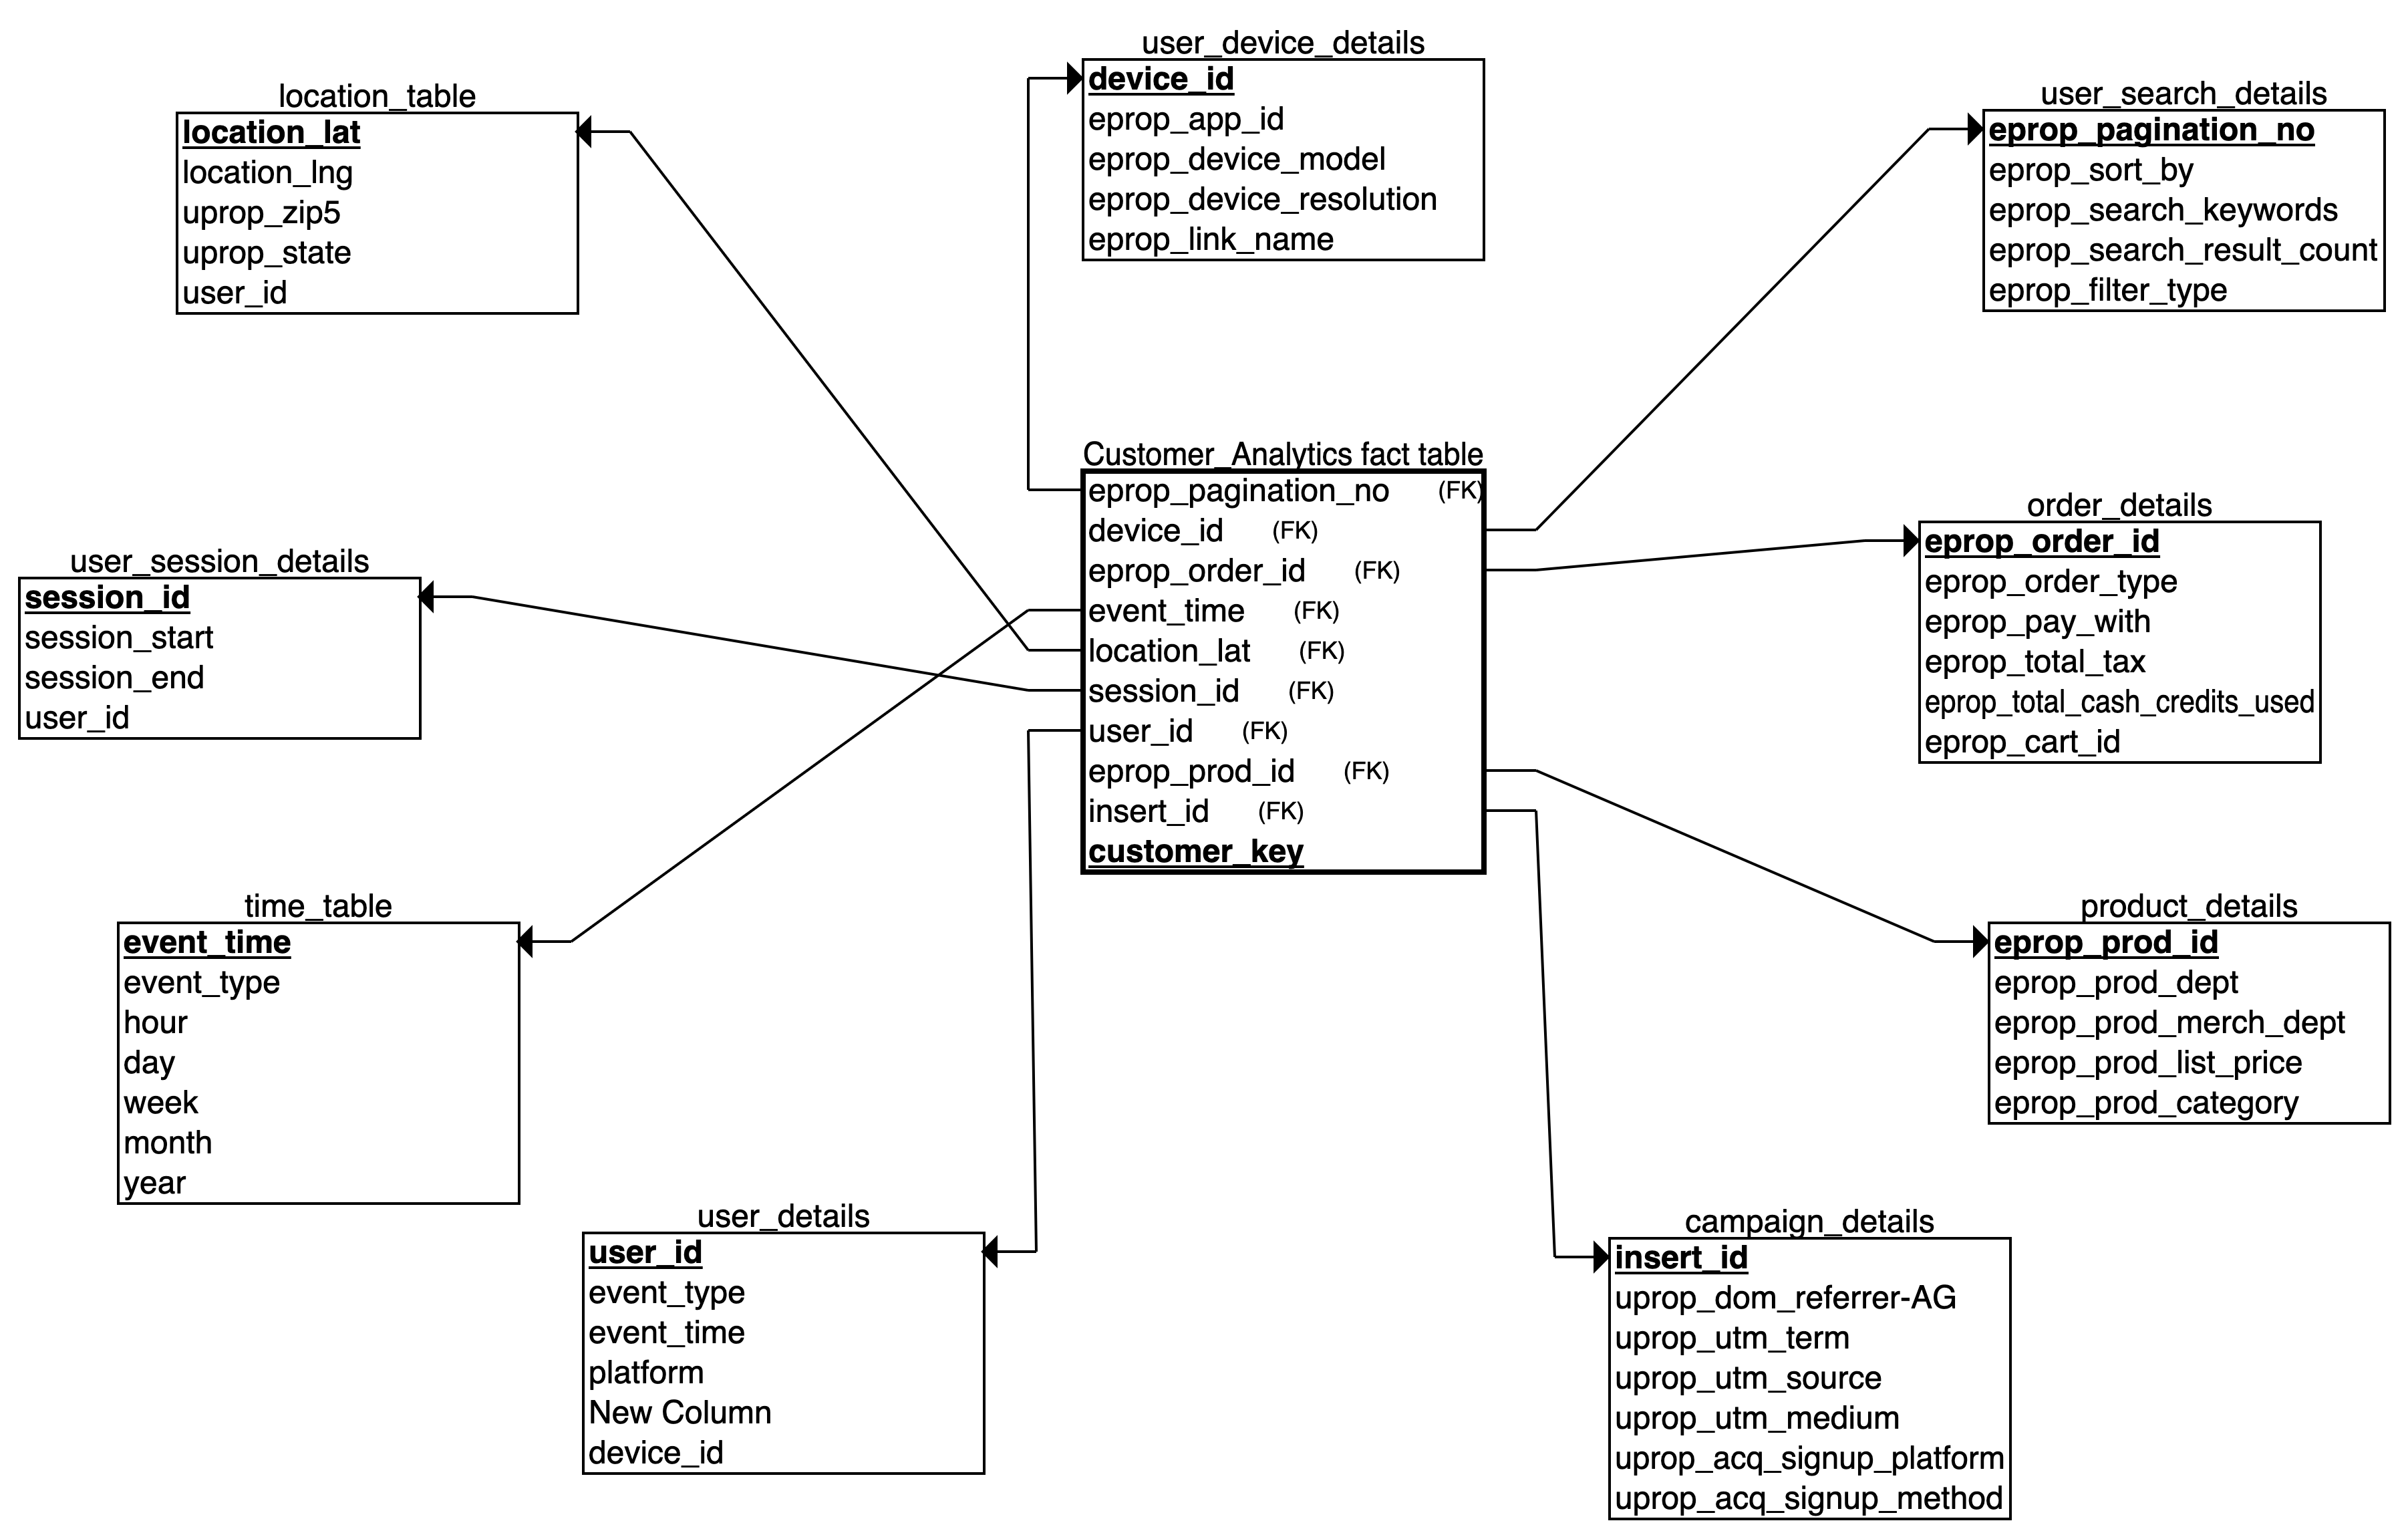

Created the dimension and fact table with temporary view and kept ready for analysis. 

#### Fact table :
    
1. customer_analytics_table

#### Dimension tables:

1. user_details_table
2. product_details_table
3. order_details_table
4. campaign_details_table
5. user_session_details_table
6. user_search_details_table
7. user_device_details_table
8. time_table
9. location_table


### Dimension 1. user_details 

In [27]:
user_details_table = df_master.select('user_id',
                                      'device_id',
                                      'event_type',
                                      'insert_id',
                                      'event_time',
                                      'session_id',
                                      'platform',
                                      'uprop_app_download_ts',
                                      'revenue',
                                      'location_lat',
                                      'location_lng',
                                      'app_version',
                                      'carrier',
                                      'os_version',
                                      'uprop_item_order_count',
                                      'uprop_bag_req_count',
                                      'uprop_last_purchase_ts',
                                      'uprop_first_purchase_ts',
                                      'uprop_total_revenue',
                                      'uprop_zip5',
                                      'uprop_state',
                                      'uprop_msa_group_name',
                                      'uprop_median_income',
                                      'uprop_hamlet_score',
                                      'uprop_user_treatments',
                                      'uprop_orders_completed_lifetime',
                                      'uprop_user_credit_balance',
                                      'uprop_user_promotion_code',
                                      'uprop_total_session_count',
                                      'uprop_total_favorites',
                                      'eprop_atc_from',
                                      'eprop_customer_status',
                                      'eprop_plp_url')

#### Count NaN Values

In [28]:
#user_details_table.select([count(when(col(c).isNull(), c)).alias(c) for c in user_details_table.columns]).show(vertical=True)


##### Remove rows without user_id

In [29]:
user_details_table.createOrReplaceTempView("user_details_temp") #creates a temporary view

In [30]:
df_user_notnull = scSpark.sql("SELECT * FROM user_details_temp where user_id IS NOT NULL")

df_user_notnull.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4,0.0,NaN,54,NaN,None,logged_in,/products/women
2,1424551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,67,NaN,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5,0.0,NaN,15,NaN,None,logged_in,None
4,12339891,0160103a6c49001a1f2ca5264e0405066001805e00718,View Product listing Page (PLP),f872f818-2d8a-493e-8028-28fd06f590ce,2017-12-01 08:00:03,1512114864000,web,NaN,NaN,41.473701,-81.579903,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,7.0,4,0.0,NaN,22,NaN,None,logged_in,/products/shoes


##### Dimension table: user_details

In [31]:
df_user_notnull.createOrReplaceTempView("user_details") 

In [32]:
df_user_temp = scSpark.sql("SELECT * FROM user_details")

df_user_temp.limit(5).toPandas()

,user_id,device_id,event_type,insert_id,event_time,session_id,platform,uprop_app_download_ts,revenue,location_lat,location_lng,app_version,carrier,os_version,uprop_item_order_count,uprop_bag_req_count,uprop_last_purchase_ts,uprop_first_purchase_ts,uprop_total_revenue,uprop_zip5,uprop_state,uprop_msa_group_name,uprop_median_income,uprop_hamlet_score,uprop_user_treatments,uprop_orders_completed_lifetime,uprop_user_credit_balance,uprop_user_promotion_code,uprop_total_session_count,uprop_total_favorites,eprop_atc_from,eprop_customer_status,eprop_plp_url
0,16878712,89ae640fa58e4f26897354a8d880df42,View homepage,15c25174-96ee-4672-b247-d6069d628e34,2017-12-01 08:00:03,1512115155000,android,NaN,NaN,NaN,NaN,4.7.9,Vodafone.de,5.0.2,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,450,NaN,None,logged_in,None
1,1612442,015f605f6efc00034f45b017f70404073003306b00bd0,View Product listing Page (PLP),39fc5cde-2dd2-46a8-bc39-26adda1a2f25,2017-12-01 08:00:03,1512112873000,web,NaN,NaN,47.680099,-122.120598,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,84.0,4,0.0,NaN,54,NaN,None,logged_in,/products/women
2,1424551,015d7b2f98e500078c82e2eea6790006f008a06700398,View Product listing Page (PLP),6c1395ab-526b-443a-9101-5e0e7e8eeac6,2017-12-01 08:00:03,1512113662000,ios,NaN,NaN,NaN,NaN,7.7.1,Verizon,10.1.1,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,NaN,3,NaN,NaN,67,NaN,None,logged_in,None
3,24254812,01600e1656840009284f97c8becd04072001806a00978,View Product details page (PDP),620db094-c933-431c-8f63-ad30f6bf9e5c,2017-12-01 08:00:03,1512108989000,web,NaN,NaN,31.510500,-97.264503,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,0.0,5,0.0,NaN,15,NaN,None,logged_in,None
4,12339891,0160103a6c49001a1f2ca5264e0405066001805e00718,View Product listing Page (PLP),f872f818-2d8a-493e-8028-28fd06f590ce,2017-12-01 08:00:03,1512114864000,web,NaN,NaN,41.473701,-81.579903,None,None,None,NaN,NaN,NaT,NaT,NaN,NaN,None,None,NaN,NaN,7.0,4,0.0,NaN,22,NaN,None,logged_in,/products/shoes


---------

### Dimension 2: product_details 

In [33]:
product_details_table = df_master.select('eprop_prod_id',
                                         'eprop_prod_dept',
                                         'eprop_prod_merch_dept',
                                         'eprop_prod_state',
                                         'eprop_prod_list_price',
                                         'eprop_prod_name',
                                         'eprop_dept_tags',
                                         'eprop_prod_color',
                                         'eprop_prod_condition',
                                         'eprop_prod_discount',
                                         'eprop_prod_sizing_id',
                                         'eprop_prod_category',
                                         'eprop_order_id',
                                         'uprop_first_purchase_ts',
                                         'uprop_last_purchase_ts',
                                         'revenue',
                                         'user_id',
                                         'session_id')

In [34]:
product_details_table.limit(5).toPandas()


,eprop_prod_id,eprop_prod_dept,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_dept_tags,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_order_id,uprop_first_purchase_ts,uprop_last_purchase_ts,revenue,user_id,session_id
0,NaN,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,16878712,1512115155000
1,NaN,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,1612442,1512112873000
2,NaN,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,1424551,1512113662000
3,27374860.0,None,women,listed,70.989998,Banana Republic Wool Coat,NaN,Gray,Q1_only,0.76,795.0,813.0,NaN,NaT,NaT,NaN,24254812,1512108989000
4,NaN,None,None,None,NaN,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,12339891,1512114864000


##### Remove rows without product_id

In [35]:
product_details_table.createOrReplaceTempView("product_details_temp") 

In [36]:
df_product_notnull = scSpark.sql("SELECT * FROM product_details_temp where eprop_prod_id IS NOT NULL")

df_product_notnull.limit(5).toPandas()

,eprop_prod_id,eprop_prod_dept,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_dept_tags,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_order_id,uprop_first_purchase_ts,uprop_last_purchase_ts,revenue,user_id,session_id
0,27374860,None,women,listed,70.989998,Banana Republic Wool Coat,NaN,Gray,Q1_only,0.76,795.0,813.0,NaN,NaT,NaT,NaN,24254812,1512108989000
1,27746639,None,women,None,7.990000,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,91444761,1512110113000
2,27574685,None,women,listed,12.990000,Style&Co Cardigan,NaN,Black,Q1_only,0.78,778.0,335.0,NaN,NaT,NaT,NaN,13861851,1512113604000
3,27118744,None,O,None,50.990002,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,2145675,1512114689000
4,24027609,None,plus,None,15.990000,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,36771861,1512115140000


##### Dimension table: product_details

In [40]:
df_product_notnull.createOrReplaceTempView("product_details") 

In [41]:
df_product_temp = scSpark.sql("SELECT * FROM product_details")

df_product_temp.limit(5).toPandas()

,eprop_prod_id,eprop_prod_dept,eprop_prod_merch_dept,eprop_prod_state,eprop_prod_list_price,eprop_prod_name,eprop_dept_tags,eprop_prod_color,eprop_prod_condition,eprop_prod_discount,eprop_prod_sizing_id,eprop_prod_category,eprop_order_id,uprop_first_purchase_ts,uprop_last_purchase_ts,revenue,user_id,session_id
0,27374860,None,women,listed,70.989998,Banana Republic Wool Coat,NaN,Gray,Q1_only,0.76,795.0,813.0,NaN,NaT,NaT,NaN,24254812,1512108989000
1,27746639,None,women,None,7.990000,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,91444761,1512110113000
2,27574685,None,women,listed,12.990000,Style&Co Cardigan,NaN,Black,Q1_only,0.78,778.0,335.0,NaN,NaT,NaT,NaN,13861851,1512113604000
3,27118744,None,O,None,50.990002,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,2145675,1512114689000
4,24027609,None,plus,None,15.990000,None,NaN,None,None,None,NaN,NaN,NaN,NaT,NaT,NaN,36771861,1512115140000


-------

### Dimension 3: order_details 
 

In [42]:
order_details_table = df_master.select('eprop_order_id',
                                        'eprop_order_type',
                                        'eprop_pay_with',
                                        'eprop_order_contains_bag',
                                        'eprop_total_shipping_fees',
                                        'eprop_total_tax',
                                        'eprop_total_discount',
                                        'eprop_item_qty',
                                        'eprop_order_asp',
                                        'eprop_total_cash_credits_used',
                                        'eprop_item_order_seq',
                                        'uprop_first_purchase_ts',
                                        'uprop_last_purchase_ts',
                                        'eprop_cart_id',
                                        'eprop_prod_id',
                                        'eprop_prod_list_price',
                                        'user_id',
                                        'session_id')

In [43]:
order_details_table.limit(5).toPandas() #Dataframe for order table

,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,uprop_first_purchase_ts,uprop_last_purchase_ts,eprop_cart_id,eprop_prod_id,eprop_prod_list_price,user_id,session_id
0,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,16878712,1512115155000
1,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,1612442,1512112873000
2,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,1424551,1512113662000
3,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,27374860.0,70.989998,24254812,1512108989000
4,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,12339891,1512114864000


##### Remove rows without order_id

In [44]:
order_details_table.createOrReplaceTempView("order_details_temp") 

In [45]:
df_order_notnull = scSpark.sql("SELECT * FROM order_details_temp where eprop_order_id IS NOT NULL")

df_order_notnull.limit(5).toPandas()

,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,uprop_first_purchase_ts,uprop_last_purchase_ts,eprop_cart_id,eprop_prod_id,eprop_prod_list_price,user_id,session_id
0,10157853,regular,braintree_apple_pay_card,NaN,0.0,NaN,100,18.0,NaN,0.0,2.0,NaT,2017-12-01 08:04:10,38705309.0,NaN,NaN,38457851,1512115312000
1,10157854,regular,braintree_credit_card,NaN,NaN,NaN,0,1.0,NaN,0.0,11.0,NaT,2017-12-01 08:04:25,38601857.0,NaN,NaN,87166291,1512115420000
2,10157882,regular,None,NaN,0.0,0.0,0,0.0,0.0,0.0,NaN,NaT,2017-12-01 08:31:01,NaN,NaN,NaN,44295841,1512116771000
3,10157910,regular,braintree_apple_pay_card,NaN,NaN,0.0,0,3.0,NaN,0.0,3.0,NaT,2017-12-01 08:54:55,38297109.0,NaN,NaN,289241,1512116214000
4,10157916,regular,None,NaN,0.0,0.0,0,0.0,0.0,0.0,NaN,NaT,2017-12-01 09:03:23,NaN,NaN,NaN,4855111,1512118700000


##### Dimension table:  order_details 

In [46]:
df_order_notnull.createOrReplaceTempView("order_details")

In [47]:
df_temp = scSpark.sql("SELECT * FROM order_details")

df_temp.limit(5).toPandas()

,eprop_order_id,eprop_order_type,eprop_pay_with,eprop_order_contains_bag,eprop_total_shipping_fees,eprop_total_tax,eprop_total_discount,eprop_item_qty,eprop_order_asp,eprop_total_cash_credits_used,eprop_item_order_seq,uprop_first_purchase_ts,uprop_last_purchase_ts,eprop_cart_id,eprop_prod_id,eprop_prod_list_price,user_id,session_id
0,10157853,regular,braintree_apple_pay_card,NaN,0.0,NaN,100,18.0,NaN,0.0,2.0,NaT,2017-12-01 08:04:10,38705309.0,NaN,NaN,38457851,1512115312000
1,10157854,regular,braintree_credit_card,NaN,NaN,NaN,0,1.0,NaN,0.0,11.0,NaT,2017-12-01 08:04:25,38601857.0,NaN,NaN,87166291,1512115420000
2,10157882,regular,None,NaN,0.0,0.0,0,0.0,0.0,0.0,NaN,NaT,2017-12-01 08:31:01,NaN,NaN,NaN,44295841,1512116771000
3,10157910,regular,braintree_apple_pay_card,NaN,NaN,0.0,0,3.0,NaN,0.0,3.0,NaT,2017-12-01 08:54:55,38297109.0,NaN,NaN,289241,1512116214000
4,10157916,regular,None,NaN,0.0,0.0,0,0.0,0.0,0.0,NaN,NaT,2017-12-01 09:03:23,NaN,NaN,NaN,4855111,1512118700000


-------

### Dimension 4 : campaign_details

In [48]:
campaign_details_table = df_master.select('insert_id',
                                          'uprop_dom_referrer',
                                          'uprop_utm_term',
                                          'uprop_utm_source',
                                          'uprop_utm_medium',
                                          'uprop_utm_content',
                                          'uprop_utm_email',
                                          'uprop_utm_campaign',
                                          'uprop_referral_code',
                                          'uprop_acq_signup_platform',
                                          'uprop_acq_signup_channel',
                                          'uprop_acq_signup_sub_channel',
                                          'uprop_acq_invitation_code',
                                          'uprop_acq_external_referrer',
                                          'uprop_acq_signup_method_agg',
                                          'uprop_acq_signup_method',
                                          'uprop_paid_acq_bucket',
                                          'eprop_order_id',
                                          'eprop_prod_id',
                                          'session_id')


In [49]:
campaign_details_table.limit(5).toPandas()

,insert_id,uprop_dom_referrer,uprop_utm_term,uprop_utm_source,uprop_utm_medium,uprop_utm_content,uprop_utm_email,uprop_utm_campaign,uprop_referral_code,uprop_acq_signup_platform,uprop_acq_signup_channel,uprop_acq_signup_sub_channel,uprop_acq_invitation_code,uprop_acq_external_referrer,uprop_acq_signup_method_agg,uprop_acq_signup_method,uprop_paid_acq_bucket,eprop_order_id,eprop_prod_id,session_id
0,15c25174-96ee-4672-b247-d6069d628e34,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,1512115155000
1,39fc5cde-2dd2-46a8-bc39-26adda1a2f25,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,1512112873000
2,6c1395ab-526b-443a-9101-5e0e7e8eeac6,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,1512113662000
3,620db094-c933-431c-8f63-ad30f6bf9e5c,www.google.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,27374860.0,1512108989000
4,f872f818-2d8a-493e-8028-28fd06f590ce,www.thredup.com,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,1512114864000


In [50]:
campaign_details_table.createOrReplaceTempView("campaign_details")

------

### Dimension 5 : user_session_details 

In [51]:
user_session_details_table = df_master.select('session_id',
                                              'session_start',
                                              'session_end',
                                              'user_id')

In [52]:
user_session_details_table.limit(5).toPandas()

,session_id,session_start,session_end,user_id
0,1512115155000,2017-12-01 07:59:15,2017-12-01 08:02:58,16878712
1,1512112873000,2017-12-01 07:21:13,2017-12-01 08:13:54,1612442
2,1512113662000,2017-12-01 07:34:22,2017-12-01 08:01:07,1424551
3,1512108989000,2017-12-01 06:16:29,2017-12-01 08:07:10,24254812
4,1512114864000,2017-12-01 07:54:24,2017-12-01 09:51:46,12339891


In [53]:
user_session_details_table.createOrReplaceTempView("user_session_details")

-------

### Dimension 6 : user_search_details 

In [54]:
user_search_details_table = df_master.select('eprop_pagination_no',
                                             'eprop_sort_by',
                                             'eprop_search_keywords',
                                             'eprop_search_result_count',
                                             'eprop_filter_type',
                                             'user_id',
                                             'session_id')

In [55]:
user_search_details_table.limit(5).toPandas()

,eprop_pagination_no,eprop_sort_by,eprop_search_keywords,eprop_search_result_count,eprop_filter_type,user_id,session_id
0,NaN,None,None,NaN,None,16878712,1512115155000
1,11.0,Price Low to High,None,NaN,Sizes,1612442,1512112873000
2,NaN,None,None,NaN,No Filters,1424551,1512113662000
3,NaN,None,None,NaN,None,24254812,1512108989000
4,1.0,Price Low to High,None,NaN,Sizes,12339891,1512114864000


In [56]:
user_search_details_table.createOrReplaceTempView("user_search_details")

------

### Dimension 7 : user_device_details 

In [57]:
user_device_details_table = df_master.select('device_id',
                                             'eprop_app_id',
                                             'eprop_device_model',
                                             'eprop_device_resolution',
                                             'eprop_link_name',
                                             'eprop_event_mythredup_sections',
                                             'eprop_cleanout_section',
                                             'session_id')

In [58]:
user_device_details_table.limit(5).toPandas()

,device_id,eprop_app_id,eprop_device_model,eprop_device_resolution,eprop_link_name,eprop_event_mythredup_sections,eprop_cleanout_section,session_id
0,89ae640fa58e4f26897354a8d880df42,None,HTCONE,NaN,None,None,None,1512115155000
1,015f605f6efc00034f45b017f70404073003306b00bd0,None,None,NaN,None,None,women,1512112873000
2,015d7b2f98e500078c82e2eea6790006f008a06700398,thredUP 7.7.1,iPhone,NaN,None,None,women,1512113662000
3,01600e1656840009284f97c8becd04072001806a00978,None,None,NaN,None,None,None,1512108989000
4,0160103a6c49001a1f2ca5264e0405066001805e00718,None,None,NaN,None,None,shoes,1512114864000


In [59]:
user_device_details_table.createOrReplaceTempView("user_device_details")

------

### Dimension 8 : time_details

In [60]:
time_details_table = df_master.select('event_time')\
                                                   .withColumn("hour", hour(col('event_time')))\
                                                   .withColumn("day", dayofmonth(col('event_time')))\
                                                   .withColumn("week", weekofyear(col('event_time')))\
                                                   .withColumn("month", month(col('event_time')))\
                                                   .withColumn("year", year(col('event_time')))\
                                                   .withColumn("weekday", dayofweek(col('event_time')))

In [61]:
time_details_table.limit(5).toPandas()

,event_time,hour,day,week,month,year,weekday
0,2017-12-01 08:00:03,8,1,48,12,2017,6
1,2017-12-01 08:00:03,8,1,48,12,2017,6
2,2017-12-01 08:00:03,8,1,48,12,2017,6
3,2017-12-01 08:00:03,8,1,48,12,2017,6
4,2017-12-01 08:00:03,8,1,48,12,2017,6


In [62]:
time_details_table.createOrReplaceTempView("time_details")

-------

### Dimension 9: location_details

In [63]:
location_details_table = df_master.select('location_lat',
                                            'location_lng',
                                            'uprop_zip5',
                                            'uprop_state',
                                            'session_id')

In [64]:
location_details_table.limit(5).toPandas()

,location_lat,location_lng,uprop_zip5,uprop_state,session_id
0,NaN,NaN,NaN,None,1512115155000
1,47.680099,-122.120598,NaN,None,1512112873000
2,NaN,NaN,NaN,None,1512113662000
3,31.510500,-97.264503,NaN,None,1512108989000
4,41.473701,-81.579903,NaN,None,1512114864000


In [65]:
location_details_table.createOrReplaceTempView("location_details")

--------

### Fact table : customer_analytics

In [66]:
customer_analytics_fact_table = df_master.select('user_id',
                                                'eprop_prod_id',
                                                'insert_id',
                                                'eprop_order_id',
                                                'device_id',
                                                'location_lat',
                                                'eprop_pagination_no',
                                                'session_id',
                                                'event_time').withColumn("customer_key",monotonically_increasing_id())

In [67]:
customer_analytics_fact_table.limit(5).toPandas()

,user_id,eprop_prod_id,insert_id,eprop_order_id,device_id,location_lat,eprop_pagination_no,session_id,event_time,customer_key
0,16878712,NaN,15c25174-96ee-4672-b247-d6069d628e34,NaN,89ae640fa58e4f26897354a8d880df42,NaN,NaN,1512115155000,2017-12-01 08:00:03,0
1,1612442,NaN,39fc5cde-2dd2-46a8-bc39-26adda1a2f25,NaN,015f605f6efc00034f45b017f70404073003306b00bd0,47.680099,11.0,1512112873000,2017-12-01 08:00:03,1
2,1424551,NaN,6c1395ab-526b-443a-9101-5e0e7e8eeac6,NaN,015d7b2f98e500078c82e2eea6790006f008a06700398,NaN,NaN,1512113662000,2017-12-01 08:00:03,2
3,24254812,27374860.0,620db094-c933-431c-8f63-ad30f6bf9e5c,NaN,01600e1656840009284f97c8becd04072001806a00978,31.510500,NaN,1512108989000,2017-12-01 08:00:03,3
4,12339891,NaN,f872f818-2d8a-493e-8028-28fd06f590ce,NaN,0160103a6c49001a1f2ca5264e0405066001805e00718,41.473701,1.0,1512114864000,2017-12-01 08:00:03,4


In [68]:
customer_analytics_fact_table.createOrReplaceTempView("customer_analytics")

-----

## 5. Analytics and Dashboards

There are many ways analytics can be generated one way is to model the data after pipeline to apply ML algorithms. Some dashboards are prescriptive, predicive and descriptive analytics which helps management team with future trends and recommendations. Few Visualization tools such as Tableau, Looker, PowerBI makes it easy to present the data.

I am going to use the SQL, matplotlib, seaborn, ans plotly for querying the data and creating the chart/graphs.

Note: I tried using zepplin and databricks notebook but file size upload issue restrain me from that approach. 

- User behavior analytics
- Campaign analytics
- Product analytics


## 1. User Behavior Analytics

These kind of analytics helps to understand the user actions by analysing the behavior of their activities.

### 1A. Count of events in general 

Event are the pages which user visits during their session while login, below query calculates the most number of pages visitied by the user.



In [69]:
df_event_count = scSpark.sql('''
          SELECT
                COUNT(event_type) AS Count_of_event,
                event_type
          FROM
                user_details 
          GROUP BY 
                event_type ''')

In [70]:
%%time
event_data = df_event_count.limit(5).toPandas()

CPU times: user 8.55 ms, sys: 4.47 ms, total: 13 ms
Wall time: 15.6 s


-------

<Figure size 900x500 with 0 Axes>

<AxesSubplot:ylabel='event_type'>

Text(0.5, 0, 'Event Page')

Text(0, 0.5, 'Count of events')

Text(0.5, 1.0, 'Event count for pages')

<Figure size 900x500 with 0 Axes>

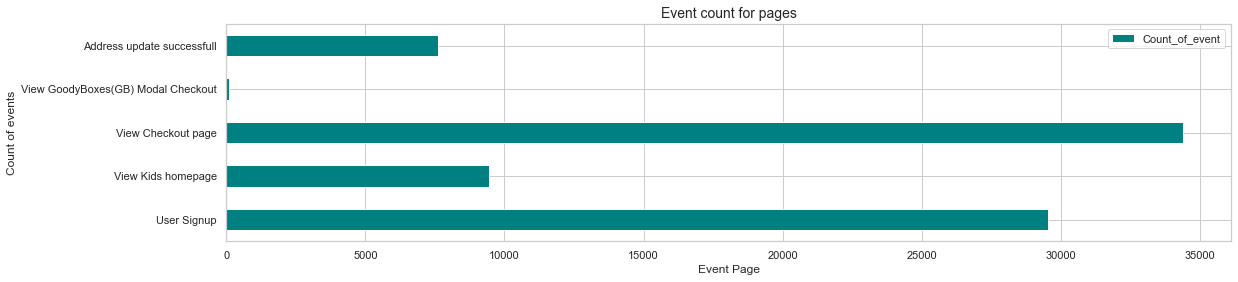

In [72]:
#Define the structure of the chart using figure and horizontal bar takes x,y axis parameters
plt.figure(figsize=(9,5), dpi = 100)
event_data.plot.barh(x='event_type', y='Count_of_event', align='center', rot=0, color='teal')

#To define X,Y axis and title name
plt.xlabel('Event Page')  
plt.ylabel('Count of events')
plt.title('Event count for pages', fontsize=14) 

-------

### 1B. Count of page views for particular day

This analysis can help to find the general stats of the users daily page views on the platform. 

In [73]:
%%time
df_page_count = scSpark.sql('''
          SELECT
                COUNT(event_type) AS page_views_count,
                DATE(event_time) 
          FROM
                user_details 
          GROUP BY 
                DATE(user_details.event_time)
        ORDER BY 
                DATE(user_details.event_time)''')

CPU times: user 888 µs, sys: 1.3 ms, total: 2.18 ms
Wall time: 42.8 ms


In [74]:
df_page_count.limit(10).toPandas()

,page_views_count,event_time
0,1327365,2017-12-01
1,2257544,2017-12-02
2,2065298,2017-12-03
3,2030055,2017-12-04
4,904246,2017-12-05


In [75]:
pdf = df_page_count.toPandas()

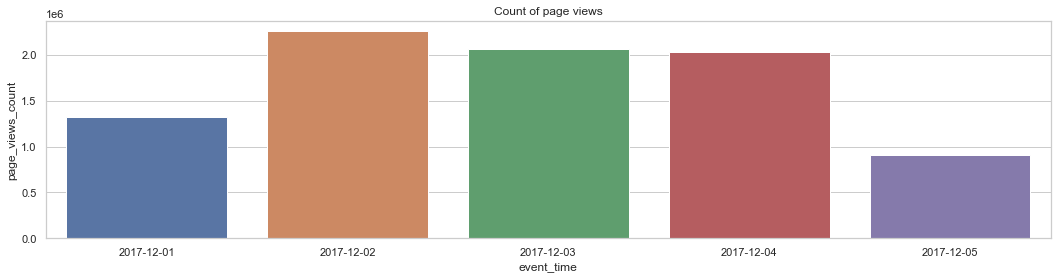

In [76]:
#Plot takes the page count views aggregated to their categorial column 

df_page_chart = sns.barplot(x='event_time', y='page_views_count', data=pdf)
df_page_chart.set_title('Count of page views');

-------

### 1C. Count of user device models

Analysis can help to find which mobile platform to more focus on considering the growth in users or in opposite if seen the slide decline in the user growth can rectify where things are going wrong.

In [77]:
df_device_model = scSpark.sql('''
                  SELECT 
                         eprop_device_model, 
                         COUNT(eprop_device_model) as device_count
                  FROM 
                         user_device_details 
                  GROUP BY
                         eprop_device_model
                  ORDER BY
                         device_count DESC''')

In [78]:
df_device = df_device_model\
                           .groupBy('eprop_device_model')\
                           .count()\
                           .orderBy('count', ascending=False)\
                           .limit(10)

In [79]:
df_device_model.limit(10).toPandas()

,eprop_device_model,device_count
0,iPhone,512123
1,iPhone 6s,383582
2,iPhone 6,281981
3,"iPhone9,1",242016
4,"iPhone9,2",162354
5,iPhone 6s Plus,160594
6,"iPhone9,3",130938
7,"iPhone8,4",117396
8,"iPhone9,4",115821
9,iPhone 6 Plus,103658


-------

### 1D. Count of daily active users 

Here we used the group by function by DataFrame

In [80]:
df_active_user = scSpark.sql('''
          SELECT
                COUNT(session_id) AS active_users,
                DATE(event_time) 
          FROM
                user_details 
          GROUP BY 
                DATE(user_details.event_time)
        ORDER BY 
                DATE(user_details.event_time)''')

In [81]:
pdf1 = df_active_user.limit(10).toPandas()

CPU times: user 41.9 ms, sys: 2.99 ms, total: 44.9 ms
Wall time: 46.6 ms


Text(0.5, 1.0, 'Count of daily active users')

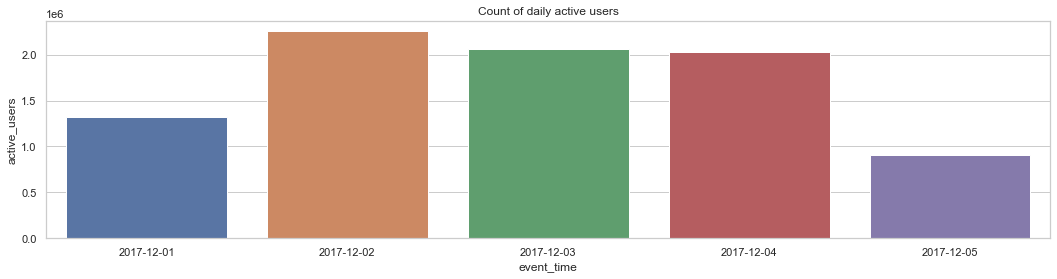

In [82]:
%%time
df_active_user = sns.barplot(x='event_time', y='active_users', data=pdf1)
df_active_user.set_title('Count of daily active users');

-------

## 2. Campaign analytics

Campaign is one of the important side to focus on while analysing the data. As it gives the further view on how much we should invest in campaigns and marketing for particular or group of customers. This also helps to define the budget and target the more leads on prospective customers.

Below are the few simple metrics for campaign analytics:

### 2A. Customer sign-up methods (TOP 10)

In [83]:
df_campaign_signup = scSpark.sql('''SELECT * FROM campaign_details WHERE uprop_acq_signup_method IS NOT NULL''')

In [84]:
df_sign_count = df_campaign_signup\
                                    .groupBy('uprop_acq_signup_method')\
                                    .count()\
                                    .orderBy('count', ascending=False)\
                                    .limit(10)

In [85]:
df_sign_count.cache().show()

+-----------------------+-----+
|uprop_acq_signup_method|count|
+-----------------------+-----+
|   mobile_web_signup...| 8206|
|            email_modal| 5625|
|   mobile_web_signup...| 3769|
|   mobile_web_facebo...| 1962|
|                 iPhone| 1670|
|   mobile_web_facebo...| 1547|
|        facebook_signup| 1187|
|   mobile_web_onboar...|  975|
|     android_smartphone|  847|
|   onboarding_modal_...|  803|
+-----------------------+-----+



<AxesSubplot:ylabel='uprop_acq_signup_method'>

Text(0.5, 0, 'Count of users')

Text(0, 0.5, 'Sign-Up method')

Text(0.5, 1.0, 'Customer Sign up Methods')

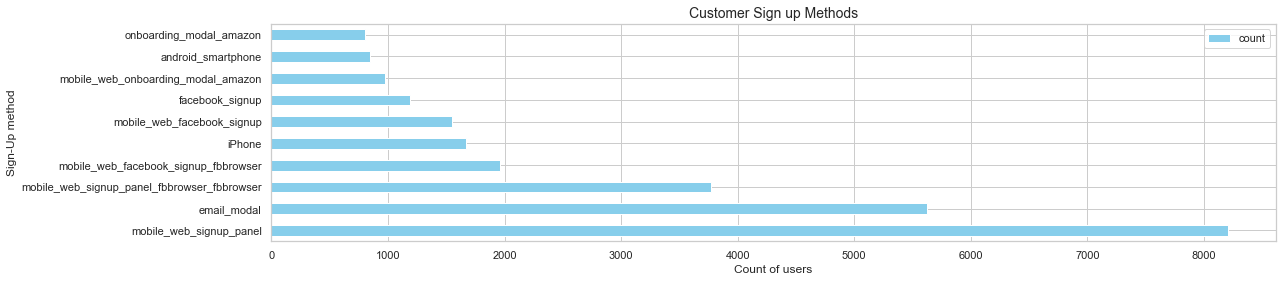

In [86]:
df_sign_count.toPandas().plot.barh(x='uprop_acq_signup_method',
                                     align='center', 
                                     color="skyblue")

plt.xlabel('Count of users')
plt.ylabel('Sign-Up method')
plt.title('Customer Sign up Methods', fontsize=14)

-------

### 2B. Percentage of customers by platform

In [87]:
df_campaign_platform = scSpark.sql('''SELECT * FROM campaign_details WHERE uprop_acq_signup_platform IS NOT NULL''')

In [88]:
df_platform_count = df_campaign_platform\
                                        .groupBy('uprop_acq_signup_platform')\
                                        .count()\
                                        .orderBy('count', ascending=False)\
                                        .limit(6)

In [89]:
df_platform_count.cache().show(10)

+-------------------------+-----+
|uprop_acq_signup_platform|count|
+-------------------------+-----+
|               mobile_web|16779|
|                      web| 8147|
|                      iOS| 2528|
|                  android| 1183|
|                    other|  879|
|                     luxe|   10|
+-------------------------+-----+



array([<AxesSubplot:ylabel='count'>], dtype=object)

Text(0.5, 1.0, 'Customers % by Platform')

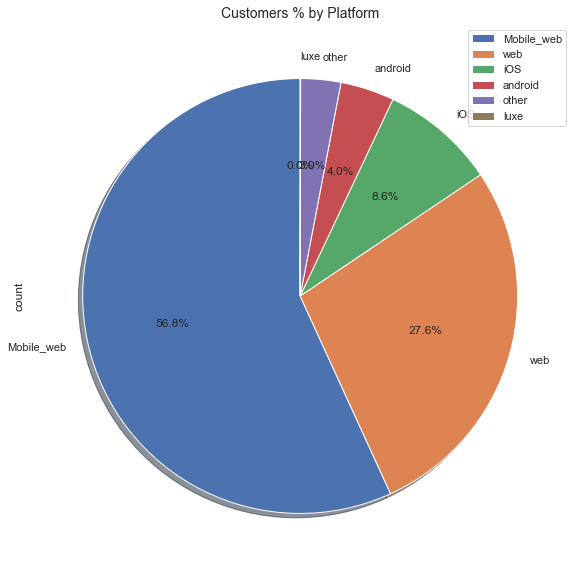

In [90]:
my_labels = 'Mobile_web','web','iOS','android','other','luxe',

df_platform_count.toPandas().plot(kind='pie', 
                                  labels=my_labels,
                                  y= 'count', 
                                  subplots=True,
                                  shadow = True,
                                  startangle=90,
                                  figsize=(15,10), 
                                  autopct='%1.1f%%')

plt.title('Customers % by Platform', fontsize=14)

-------

### 2C. Customer count by zip code

In [91]:
df_campaign_zip = scSpark.sql('''SELECT * FROM user_details WHERE uprop_zip5 IS NOT NULL''') 

In [92]:
df_user_zip = df_campaign_zip\
                             .groupBy('uprop_zip5')\
                             .count()\
                             .orderBy('count', ascending=False)\
                             .limit(5)

In [93]:
df_user_zip.cache().show()


+----------+-----+
|uprop_zip5|count|
+----------+-----+
|     75270|  160|
|     77002|  149|
|     60602|  147|
|     19107|   79|
|     10029|   76|
+----------+-----+



<AxesSubplot:xlabel='uprop_zip5'>

Text(0, 0.5, 'Customer count')

Text(0.5, 0, 'ZIP Codes')

Text(0.5, 1.0, 'Top 5 customers by ZIP code')

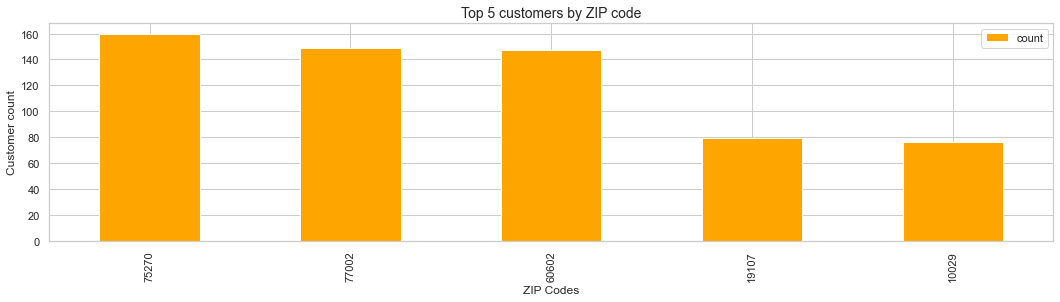

In [94]:
df_user_zip.toPandas().plot.bar(x='uprop_zip5', align='center', color='orange')
plt.ylabel('Customer count')
plt.xlabel('ZIP Codes')
plt.title('Top 5 customers by ZIP code', fontsize=14)

-------

## 3. Product Analytics

### 3A. Ranking the products

Dense rank window function creates a parition on columns and rank the rows based on the partition results set. 

Note: Revenue column had null values but I fill in with random values and try to rank the products

In [95]:
df_product_rev = scSpark.sql('''
             SELECT 
                   eprop_prod_id,
                   eprop_prod_name, 
                   eprop_prod_category,
                   revenue, 
                   dense_rank
             FROM 
                  (SELECT
                         DISTINCT(eprop_prod_id),
                         eprop_prod_name, 
                         eprop_prod_category, 
                         revenue,
                         DENSE_RANK(revenue)
                                    OVER (PARTITION BY eprop_prod_category 
                                    ORDER BY revenue DESC) AS dense_rank
                   FROM 
                         product_details  
                   )a
             WHERE 
                    dense_rank <= 3
                 ''').withColumn("revenue",when(rand() > 0.5, 1).otherwise(0))

In [96]:
df_product_rev.limit(10).toPandas()

,eprop_prod_id,eprop_prod_name,eprop_prod_category,revenue,dense_rank
0,28595651,Tykes Short Sleeve Onesie,148,1,1
1,28261817,Baby Gap Short Sleeve Onesie,148,1,1
2,28211366,Baby Gap Short Sleeve Onesie,148,0,1
3,20583384,The Children's Place Short Sleeve Onesie,148,0,1
4,28390258,Carter's Short Sleeve Onesie,148,1,1
5,28295707,Wrangler Jeans Co Short Sleeve Onesie,148,0,1
6,28535659,Nfl Short Sleeve Onesie,148,0,1
7,28053532,Cat & Jack Short Sleeve Onesie,148,1,1
8,28535959,Nfl Short Sleeve Onesie,148,0,1
9,27276824,Carter's Short Sleeve Onesie,148,0,1


------

### 3B. Product Purchase date (check for returning customer)

We are trying to find out the user is a returning customer, using last purchase date column we find the first order date for the user and then partition on user_id to see if user has order any product after that

In [97]:
df_purchase_return = scSpark.sql('''
                     SELECT 
                           user_id,
                           uprop_last_purchase_ts, 
                           FIRST(uprop_last_purchase_ts) 
                                 OVER (PARTITION BY user_id ORDER BY uprop_last_purchase_ts)
                                 AS first_order_date, 
                      CASE 
                           WHEN FIRST(uprop_last_purchase_ts) 
                                      OVER (PARTITION BY user_id 
                                      ORDER BY uprop_last_purchase_ts) = uprop_last_purchase_ts then 1 else 0 
                      END AS
                           returning_customer
                      FROM 
                           order_details
                      ORDER BY 
                           uprop_first_purchase_ts, 
                           uprop_last_purchase_ts''')

In [98]:
df_purchase_return.limit(10).toPandas()

,user_id,uprop_last_purchase_ts,first_order_date,returning_customer
0,882774,2017-12-01 08:01:00,2017-12-01 08:01:00,1
1,7875861,2017-12-01 08:01:50,2017-12-01 08:01:50,1
2,959394,2017-12-01 08:02:58,2017-12-01 08:02:58,1
3,1999461,2017-12-01 08:03:13,2017-12-01 08:03:13,1
4,38457851,2017-12-01 08:04:10,2017-12-01 08:04:10,1
5,87166291,2017-12-01 08:04:25,2017-12-01 08:04:25,1
6,2832941,2017-12-01 08:05:23,2017-12-01 08:05:23,1
7,7458238,2017-12-01 08:06:35,2017-12-01 08:06:35,1
8,413322,2017-12-01 08:06:55,2017-12-01 08:06:55,1
9,852531,2017-12-01 08:08:02,2017-12-01 08:08:02,1


------

### 3C. User first and last purchase difference in days and months

We have first_purchase_date column null but still we can find the maximum days of time user has not ordered anything from the merchandise

In [99]:
df_purchase_diff = scSpark.sql('''
                   SELECT 
                         user_id,
                         uprop_first_purchase_ts,
                         uprop_last_purchase_ts, 
                         DATEDIFF( uprop_last_purchase_ts, uprop_first_purchase_ts ) AS diff_in_days,
                                   CAST( months_between( uprop_last_purchase_ts, uprop_first_purchase_ts ) AS INT) AS diff_in_months      
                   FROM 
                         order_details
                   ORDER BY 1''')

In [100]:
df_purchase_diff.limit(10).toPandas()

,user_id,uprop_first_purchase_ts,uprop_last_purchase_ts,diff_in_days,diff_in_months
0,111131,NaT,2017-12-01 15:43:04,NaN,NaN
1,111212,NaT,2017-12-01 16:55:41,NaN,NaN
2,111238,NaT,2017-12-03 00:12:21,NaN,NaN
3,111322,2017-12-02 17:40:59,2017-12-02 17:40:59,0.0,0.0
4,11136931,NaT,2017-12-04 04:53:29,NaN,NaN
5,111376,NaT,2017-12-02 11:35:43,NaN,NaN
6,1114241,NaT,2017-12-04 18:32:51,NaN,NaN
7,111434,NaT,2017-12-05 02:04:20,NaN,NaN
8,11148112,2017-12-01 16:46:27,2017-12-01 16:46:27,0.0,0.0
9,1115332,NaT,2017-12-04 01:52:04,NaN,NaN


-------

### 3D. Cumulative amount spent by each customer

In [101]:
df_product_cumulate = scSpark.sql('''
                     SELECT
                             * 
                     FROM 
                            product_details
                     WHERE
                            user_id 
                     IS NOT NULL  ''') 

In [102]:
df_product_cumulate.createOrReplaceTempView("product_details_amount") 

In [103]:
df_purchase_cum = scSpark.sql('''
              SELECT 
                     user_id,
                     eprop_prod_id, 
                     eprop_prod_name,
                     uprop_last_purchase_ts, 
                     eprop_prod_list_price, 
                     ROUND(SUM(eprop_prod_list_price) 
                           OVER (PARTITION BY user_id 
                                 ORDER BY uprop_last_purchase_ts ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), 2) AS cum_expense
              FROM 
                     product_details_amount
              GROUP BY
                     user_id,
                     eprop_prod_id,
                     eprop_prod_name,
                     uprop_last_purchase_ts,
                     eprop_prod_list_price
              ORDER BY 
                     user_id,
                     uprop_last_purchase_ts''')

In [104]:
df_purchase_cum.limit(10).toPandas()

,user_id,eprop_prod_id,eprop_prod_name,uprop_last_purchase_ts,eprop_prod_list_price,cum_expense
0,11111322,27737876,Anna Sui Faux Fur Jacket,NaT,94.989998,131.98
1,11111322,27127751,Adrienne Vittadini Faux Fur Jacket,NaT,33.990002,240.95
2,11111322,28643839,Express Faux Fur Jacket,NaT,41.990002,324.93
3,11111322,27233987,Express Faux Fur Jacket,NaT,41.990002,282.94
4,11111322,27854363,Roaman's Faux Fur Jacket,NaT,36.990002,36.99
5,11111322,28616226,H&M Faux Fur Jacket,NaT,13.990000,206.96
6,11111322,25063726,Banana Republic Faux Fur Jacket,NaT,60.990002,192.97
7,1111171,28568574,Victoria's Secret Pink Sweatshirt,NaT,20.990000,20.99
8,1111194,26317630,Coach Crossbody Bag,NaT,88.989998,393.98
9,1111194,28024004,Baggallini Crossbody Bag,NaT,42.990002,436.97


### 3E. Moving Average of price for each customer

In [105]:
df_mov_avg = scSpark.sql('''
             SELECT  
                   user_id,
                   session_id,
                   eprop_prod_list_price, 
                   ROUND(AVG(eprop_prod_list_price) 
                         OVER (PARTITION BY user_id 
                         ORDER BY session_id ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING), 2) AS moving_avg
             FROM 
                   product_details_amount
             ORDER BY
                   user_id,
                   session_id''')

In [106]:
df_mov_avg.limit(10).toPandas()

,user_id,session_id,eprop_prod_list_price,moving_avg
0,11111322,1512235554000,33.990002,37.99
1,11111322,1512235554000,94.989998,57.99
2,11111322,1512235554000,13.990000,37.49
3,11111322,1512235554000,41.990002,56.99
4,11111322,1512235554000,36.990002,57.99
5,11111322,1512235554000,41.990002,46.66
6,11111322,1512235554000,60.990002,38.99
7,1111171,1512328271000,20.990000,20.99
8,1111194,1512182631000,88.989998,65.99
9,1111194,1512212945000,42.990002,145.66


### Write data to Parquet File

In [107]:
df_mov_avg.write.parquet("platform_count/df_mov_avg.parquet")

### Few approaches, I have experienced implementing before for ETL data pipelines and further analytics:
    1. Data Pipeline with MySQL and Pentaho
      - Database - MySQL
      - Integration tool - Pentaho
      - Reporting and Dashboards - Tableau   
   Reference :  [Port and Shipment Data Analysis](https://github.com/mohitcpatil/Ports-and-Shipment-Data-Analytics)
    
    2. Data Pipeline with Cassandra and Redshift 
      - Database - Apache Cassandra
      - Integration tool - AWS Redshift
      - Storage - AWS S3      
   Reference :  [Sparkify Data Warehouse AWS Redshift](https://github.com/mohitcpatil/Data-Engineering-Nanodegree-Udacity-Program-Projects-and-Excercise/tree/master/M2%20Cloud%20Data%20Warehouse/Project%203%20Cloud%20Data%20Warehouse%20with%20AWS)     
 
    3. Data Analysis and Visualization in Pandas & NumPy    
   Reference : [Boston Marathon Analysis](https://github.com/mohitcpatil/Boston-Marathon-Analysis)     
 
         
    4. Data modeling with PostgreSQL and Apache Cassandra     
   Reference:  [Data modeling in SQL & NoSQL database](https://github.com/mohitcpatil/Data-Engineering-Nanodegree-Udacity-Program-Projects-and-Excercise/tree/master/M1%20Data%20Modeling)     
   

    

### Futuristic step:
    
Spark provides MLlib a machine learning library for developing the ML models. This libary provides the whole framework from preprocessing and munging the data which then used for training the models for predictions. The pipeline architecture shown above resonate the futuristic step as well.